In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import MaxPool2D
from random import shuffle
from glob import glob
import tqdm
import os
import re
import warnings
warnings.filterwarnings('ignore')

### Data Import

In [2]:
train_count = 5000
test_count = 1000

train = glob("./data/dataset/train/*.jpeg")
test = glob("./data/dataset/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_count]
test = test[:test_count]

# piece symbols to be used in FEN definitions
piece_symbols = 'prbnkqPRBNKQ'

### Data Exploration

In [3]:
def fen_from_file(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

#### Fen Samples

In [4]:
print(fen_from_file(train[0]), '\n', fen_from_file(train[1]), '\n', fen_from_file(train[2]))

N1nq3N-1K6-1Qr2p2-2r4R-4q3-8-3R4-1Bk2B2 
 b7-8-B2K4-5p2-r7-pP6-R1R3k1-n2n3B 
 1N1R1k2-6Nn-8-4p3-8-1R1B1Qn1-K7-2r2N2


#### Image samples

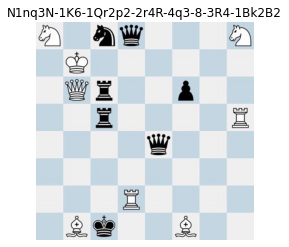

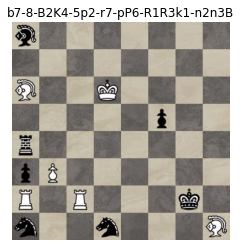

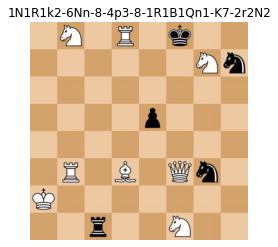

In [5]:
for i in range(0,3):
    plt.title(fen_from_file(train[i]))
    plt.imshow(mpimg.imread(train[i]))
    plt.axis('off')
    plt.show()

In [6]:
# images to array
def images(images_path, image_height, image_width):
    image_list = []

    for image in tqdm(os.listdir(images_path)):
        path = os.path.join(images_path, image)

        image = cv2.imread(path)
        image = cv2.resize(image , (image_height, image_width))
        image_list.append([np.array(image)])
    
    shuffle(image_list)

    array_image = np.array(image_list)

    images = array_image[:,0,:,:]

    return(images)

### FEN encoding to be able to use as a feature in training

In [7]:
def onehot_from_fen(fen):
    eye = np.eye(NB_CLASSES)
    output = np.empty((0, NB_CLASSES))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, NB_CLASSES)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

#### Proccess images

In [8]:
# downsample images - split to chess board squares - flatten and reshape
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)

    return tiles.reshape(64, square_size, square_size, 3)

### Functions for sampling batches for training and evaluation

In [9]:
def train_gen(features):
    for _, img in enumerate(features):
        y = onehot_from_fen(fen_from_file(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

### Define the model

In [10]:
# Set training parameters
img_rows = 25
img_cols = 25
EPOCHS = 100
BATCH_SIZE = 8
NB_CLASSES = 13

In [11]:
model = Sequential()
# Convolutional 2D layer
model.add(Convolution2D(15, kernel_size=2, activation='relu', 
          input_shape=(img_rows, img_cols, 3)))
# Pooling operation
model.add(MaxPool2D(2))
# Add another convolutional layer
model.add(Convolution2D(5, kernel_size=2, activation='relu'))
# Flatten and feed to output layer
model.add(Flatten())
# Add a dropout layer
model.add(Dropout(0.3))
# Output layer
model.add(Dense(13, activation='softmax'))
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 15)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 5)         305       
                                                                 
 flatten (Flatten)           (None, 605)               0         
                                                                 
 dropout (Dropout)           (None, 605)               0         
                                                                 
 dense (Dense)               (None, 13)      

2022-08-05 23:03:31.713804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 23:03:31.713881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Train the model

In [13]:
# Fit params
history = model.fit_generator(
    train_gen(train), steps_per_epoch=len(train)//EPOCHS,
    epochs=EPOCHS, verbose=1, validation_data=train_gen(test),
    validation_steps=len(test)//EPOCHS
)

Epoch 1/100


2022-08-05 23:03:32.017767: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/50 [..............................] - ETA: 16s - loss: 2.5472 - accuracy: 0.0625

2022-08-05 23:03:32.219311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 21ms/step - loss: 1.2337 - accuracy: 0.7753 - val_loss: 0.8314 - val_accuracy: 0.8484
Epoch 2/100
 1/50 [..............................] - ETA: 0s - loss: 0.7313 - accuracy: 0.8594

2022-08-05 23:03:33.207316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 19ms/step - loss: 0.8108 - accuracy: 0.8316 - val_loss: 0.7041 - val_accuracy: 0.8438
Epoch 3/100
50/50 [==============================] - 1s 20ms/step - loss: 0.6529 - accuracy: 0.8472 - val_loss: 0.5355 - val_accuracy: 0.8641
Epoch 4/100
50/50 [==============================] - 1s 20ms/step - loss: 0.6105 - accuracy: 0.8400 - val_loss: 0.3939 - val_accuracy: 0.9047
Epoch 5/100
50/50 [==============================] - 1s 20ms/step - loss: 0.4436 - accuracy: 0.8769 - val_loss: 0.4518 - val_accuracy: 0.8766
Epoch 6/100
50/50 [==============================] - 1s 20ms/step - loss: 0.3634 - accuracy: 0.8978 - val_loss: 0.2758 - val_accuracy: 0.9406
Epoch 7/100
50/50 [==============================] - 1s 19ms/step - loss: 0.3119 - accuracy: 0.9191 - val_loss: 0.3273 - val_accuracy: 0.8797
Epoch 8/100
50/50 [==============================] - 1s 20ms/step - loss: 0.2689 - accuracy: 0.9253 - val_loss: 0.2095 - val_accuracy: 0.9391
Epoch 9/100
50/50 

In [14]:
# # save the model to call it later when needed
# model.save('model.h5')

### Performance Evaluation

In [15]:
res = (
    model.predict_generator(pred_gen(test, 64), steps=test_count)
    .argmax(axis=1)
    .reshape(-1, 8, 8)
)

2022-08-05 23:05:10.890058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_file(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Accuracy: {:2f}".format(final_accuracy))

Accuracy: 0.958000


In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


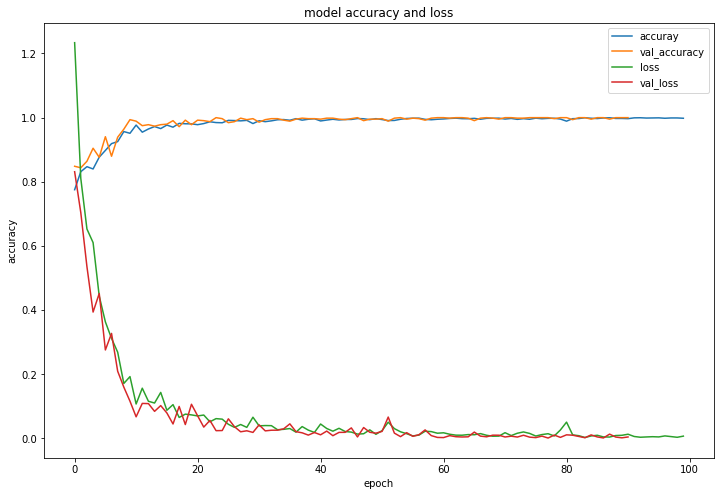

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuray', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
plt.show()

#### Sample image prediction

In [19]:
def predicted_fen_plot(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

2/2 [==============================] - 0s 6ms/step


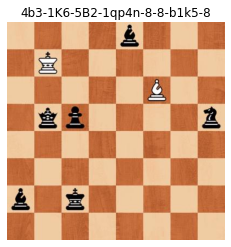

2/2 [==============================] - 0s 2ms/step


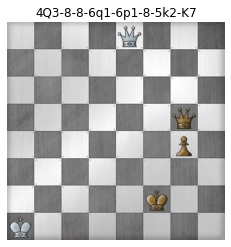

2/2 [==============================] - 0s 2ms/step


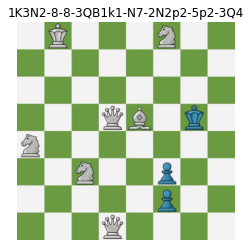

None None None


In [20]:
print(predicted_fen_plot(test[0]), predicted_fen_plot(test[1]), predicted_fen_plot(test[2]))